In [1]:
from Stacking_lib import *
from ReCalibration import *
from Bagging_models import *
from NN_fed_GPR import *
from NN_fed_RF import *
from RF_fed_GPR import *
from Single_UQ_models import *
import itertools



labels_to_predict = ['impact site x', 'impact site y', 'height']

all_labels = ['height', 'phi', 'theta', 
                            'impact site x', 'impact site y', 'impact site z', 
                            'impact site r', 'impact site phi', 'impact site theta']

with_or_without_transformations = 'without'

KING_path = f'/Volumes/Jake_ssd/Stacking'
model_folder = KING_path + f'/models'
data_folder = KING_path + '/5fold_datasets'
results_folder = KING_path + '/results'
hyperparam_folder = f'/Volumes/Jake_ssd/Paper 2/without_transformations' + f'/bayesian_optimization_{with_or_without_transformations}_transformations'

if(with_or_without_transformations == 'with'):
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/dataset/feature_transformations_2023-11-16/height/HEIGHTALL_TRANSFORMED_FEATURES.csv"
    backward_feat_selection_results_folder = '/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/results'
else:
    # full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_no_feature_engineering/dataset/New_Crack_Len_FULL_OG_dataframe_2023_11_16.csv"
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 2/New_Crack_Len_FULL_OG_dataframe_2024_02_22.csv"
    backward_feat_selection_results_folder = KING_path + '/Paper_2_results_WITHOUT_feature_engineering/results' 
    df = pd.read_csv(full_dataset_pathname, index_col=0)
    all_features = df.columns
    all_features = all_features.drop(all_labels)
    all_features = str(all_features.drop('timestep_init').to_list())
    print('all features = ' + str(all_features))
    
model_types = ['ANN', 'GPR', 'RF', 'ridge', 'Single RF', 'Single GPR', 'NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR']
# model_types = ['ridge', 'Single RF', 'Single GPR']

predictions = {'impact site x': {}, 'impact site y': {}, 'height': {}}
results = {}

forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git
XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal
scikit-lego is an optional dependency, enabling use of the LowessRegression model. If you want to use this model, do "pip install scikit-lego"
all features = ['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_

MAKE THE DATASETS (WE NEED A TRAINING, VALIDATION AND TESTING DATASET)

In [2]:
'''Making the datasets, but the validation set is called the calibration set here...'''
# make_5_fold_datasets_with_calibration_set(data_folder, full_dataset_pathname)

'Making the datasets, but the validation set is called the calibration set here...'

In [3]:
'''Now we need to train the base models on the training set'''
num_models = 20 #number of weak learners for bagging models

for label_to_predict in labels_to_predict:
    results[label_to_predict] = {}
    for model_type in model_types:
        for fold_no in range(1,6):
            results[label_to_predict][model_type] = {}
            print(f'PREDICTING {label_to_predict} USING {model_type}')
            all_percentages_inside_ranges = {'uncalibrated': [], 'calibrated': []}
            
            print(f'\n$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting {label_to_predict} using {model_type} $$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n')

            training_features = pd.read_csv(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_features.csv').reset_index(drop=True)
            training_labels = pd.read_csv(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_labels.csv').reset_index(drop=True)
            features_to_keep = training_features.columns.to_list()


            '''If the model is an ensemble type, then we train it using the code below'''
            if(model_type in ['ANN', 'RF', 'GPR', 'ridge']):
                print(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_features.csv')

                model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/{num_models}_models/fold_{fold_no}'
                if(not os.path.exists(model_saving_folder)):
                    os.makedirs(model_saving_folder)
                    
                results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/{num_models}_models/fold_{fold_no}'
                if(not os.path.exists(results_saving_folder)):
                    os.makedirs(results_saving_folder)

                make_linear_regression_models_for_ensemble(training_features, training_labels, model_saving_folder, label_to_predict, num_models, features_to_keep, hyperparam_folder, model_type=model_type)
            
            elif(model_type in ['NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR', 'Single GPR', 'Single RF']):
                print(f'\n$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting {label_to_predict} using {model_type} $$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n')

                model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
                if(not os.path.exists(model_saving_folder)):
                    os.makedirs(model_saving_folder)
                    
                results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
                if(not os.path.exists(results_saving_folder)):
                    os.makedirs(results_saving_folder)


                make_UQ_model(training_features, training_labels, model_saving_folder, label_to_predict, 1, features_to_keep, hyperparam_folder, model_type=model_type)
            
            #TODO: NOW WE NEED TO TRAIN THE CLASSIFIERS
            # elif()
                

PREDICTING impact site x USING ANN

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting impact site x using ANN $$$$$$$$$$$$$$$$$$$$$$$$$$$$$

/Volumes/Jake_ssd/Stacking/5fold_datasets/impact site x/fold1/train_features.csv
working on model 0


patience reached
End train R2 score = 0.965994006873763 validation R2 score = 0.84478199988297
working on model 1
patience reached
End train R2 score = 0.9592863024908769 validation R2 score = 0.8608486355631612
working on model 2
patience reached
End train R2 score = 0.9705655758493886 validation R2 score = 0.8015727718588489
working on model 3
patience reached
End train R2 score = 0.9631830766647637 validation R2 score = 0.7923391364833781
working on model 4
patience reached
End train R2 score = 0.9683322110404066 validation R2 score = 0.9098764425197993
working on model 5
patience reached
End train R2 score = 0.9647654750903415 validation R2 score = 0.8537259598052982
working on model 6
patience reached
End train R2 score = 0.9256455469944727 validation R2 score = 0.751527100058146
working on model 7
patience reached
End train R2 score = 0.9695968136939411 validation R2 score = 0.8291186288560063
working on model 8
patience reached
End train R2 score = 0.9523510192338891 validation 

In [4]:
'''Now we can train the meta model using the other model's output. we train the meta model on the validation set.'''
meta_model_type = 'linear'
all_meta_models = {}

for label_to_predict in labels_to_predict:
    all_meta_models[label_to_predict] = []
    for fold_no in range(1,6):
        results = {}
        base_model_outputs = {}
        for model_type in model_types:
            validation_features_path = f'/Volumes/Jake_ssd/Stacking/5fold_datasets/{label_to_predict}/fold{fold_no}/calibration_features.csv'
            validation_labels_path = f'/Volumes/Jake_ssd/Stacking/5fold_datasets/{label_to_predict}/fold{fold_no}/calibration_labels.csv'
            
            
            r2, predictions, uncertanties, labels = make_predictions(model_type, 
                                                                    model_folder, 
                                                                    label_to_predict, 
                                                                    num_models,
                                                                    fold_no, 
                                                                    validation_features_path, 
                                                                    validation_labels_path, 
                                                                    results_folder, 
                                                                    features_to_keep)
            
            results[model_type] = r2
            
            
            base_model_outputs[model_type] = predictions

        base_model_outputs = pd.DataFrame(base_model_outputs)
        base_model_results_path = f'/Volumes/Jake_ssd/Stacking/stacking_results/base_models/{label_to_predict}'
        if(not os.path.exists(base_model_results_path)): os.makedirs(base_model_results_path)
        print(results)
        # base_model_results = pd.DataFrame(results)
        base_model_results = pd.DataFrame(list(results.items()), columns=['model_type', 'score'])
        base_model_results.to_csv(base_model_results_path + f'/base_model_results_fold_{fold_no}.csv')
        
        '''get the subsets of model_types'''
        all_meta_models[label_to_predict] = {}
        subsets = []
        for r in range(2, len(model_types) + 1):
            subsets.extend(itertools.combinations(model_types, r))
        # Convert tuples to lists
        subsets = [list(subset) for subset in subsets]
        # Print the subsets
        for subset in subsets: 
            meta_model = train_meta_model(meta_model_type, base_model_outputs[subset], labels)
            all_meta_models[label_to_predict][str(subset)] = meta_model
        
        if(not os.path.exists(model_folder + f'/{label_to_predict}/meta_models')): os.makedirs(model_folder + f'/{label_to_predict}/meta_models')
        with open(model_folder + f'/{label_to_predict}/meta_models/fold_{fold_no}_meta_models.pkl', 'wb') as pickle_file:
            pickle.dump(all_meta_models, pickle_file)

{'ANN': 0.7661854249187864, 'GPR': -0.01131448833156834, 'RF': 0.8167948599704788, 'ridge': 0.7043926372357754, 'Single RF': 0.8189759101802673, 'Single GPR': 0.020602887212634147, 'NN_fed_GPR': 0.8010850085393074, 'NN_fed_RF': 0.7445064213383581, 'RF_fed_GPR': 0.8348762604444926}
{'ANN': 0.5974795126770489, 'GPR': 0.016498139036502324, 'RF': 0.7323718410469221, 'ridge': 0.47256763056304174, 'Single RF': 0.7058468283474112, 'Single GPR': 0.023188245966570653, 'NN_fed_GPR': 0.6534584706148299, 'NN_fed_RF': 0.6645234102711126, 'RF_fed_GPR': 0.7131636785285851}
{'ANN': 0.5194887009433762, 'GPR': -0.012304220346642358, 'RF': 0.757198349281429, 'ridge': 0.5904731026835431, 'Single RF': 0.7677381170012589, 'Single GPR': -0.011829086710509307, 'NN_fed_GPR': 0.703608220097392, 'NN_fed_RF': 0.7171849664133868, 'RF_fed_GPR': 0.7947081845951235}
{'ANN': 0.7888040087614859, 'GPR': -0.0034686238310814854, 'RF': 0.8431528967917203, 'ridge': 0.695401803034263, 'Single RF': 0.8833974757557589, 'Single

In [6]:
'''Now we can test the performance of the meta model against the performance of the base models'''
stacking_results_folder = f'/Volumes/Jake_ssd/Stacking/stacking_results'
for label_to_predict in labels_to_predict:
    print(f'predicting {label_to_predict}')
    for fold_no in range(1,6):
        base_model_outputs = {}
        for model_type in model_types:
            test_features_path = f'/Volumes/Jake_ssd/Stacking/5fold_datasets/{label_to_predict}/fold{fold_no}/calibration_features.csv'
            test_labels_path = f'/Volumes/Jake_ssd/Stacking/5fold_datasets/{label_to_predict}/fold{fold_no}/calibration_labels.csv'
            
            
            r2, predictions, uncertanties, labels = make_predictions(model_type, 
                                                        model_folder, 
                                                        label_to_predict, 
                                                        num_models,
                                                        fold_no, 
                                                        test_features_path, 
                                                        test_labels_path, 
                                                        results_folder, 
                                                        features_to_keep)
            print(f'{model_type} score = {r2}')
            base_model_outputs[model_type] = predictions
            
        
        results = {}
        with open(model_folder + f'/{label_to_predict}/meta_models/fold_{fold_no}_meta_models.pkl', 'rb') as pickle_file:
            all_meta_models = pickle.load(pickle_file)
        '''get the subsets of model_types'''
        subsets = []
        for r in range(2, len(model_types) + 1):
            subsets.extend(itertools.combinations(model_types, r))
        # Convert tuples to lists
        subsets = [list(subset) for subset in subsets]
        # Print the subsets
        for subset in subsets:    
            print(subset)    
            base_model_outputs = pd.DataFrame(base_model_outputs)
            # print(all_meta_models)
            meta_model = all_meta_models[label_to_predict][str(subset)]
            test_predictions = make_meta_predictions(meta_model, base_model_outputs[subset]) 
            final_r2 = r2_score(labels, test_predictions)
            print(f'final score = {final_r2}\n')
            results[str(subset)] = final_r2
        
        print(results)
        results = pd.DataFrame(list(results.items()), columns=['Model_subsets', 'Score'])
        # results.to_csv(f'/Volumes/Jake_ssd/Stacking/stacking_results/meta_models/{label_to_predict}/stacked_model_results_fold_{fold_no}.csv')
        results.to_csv(f'/Volumes/Jake_ssd/Stacking/stacking_results/base_models/{label_to_predict}/stacked_model_results_fold_{fold_no}.csv')
        
        
        
        
            

            


predicting impact site x
ANN score = 0.7661854249187864
GPR score = -0.01131448833156834
RF score = 0.8167948599704788
ridge score = 0.7043926372357754
Single RF score = 0.8189759101802673
Single GPR score = 0.020602887212634147
NN_fed_GPR score = 0.8010850085393074
NN_fed_RF score = 0.7445064213383581
RF_fed_GPR score = 0.8348762604444926
['ANN', 'GPR']
final score = 0.8296129624722277

['ANN', 'RF']
final score = 0.8514030843930814

['ANN', 'ridge']
final score = 0.8293283026281019

['ANN', 'Single RF']
final score = 0.8573805004657233

['ANN', 'Single GPR']
final score = 0.8296542162207721

['ANN', 'NN_fed_GPR']
final score = 0.835496368497223

['ANN', 'NN_fed_RF']
final score = 0.8291827883800037

['ANN', 'RF_fed_GPR']
final score = 0.8592642707797387

['GPR', 'RF']
final score = 0.8594456099125909

['GPR', 'ridge']
final score = 0.7333353138710481

['GPR', 'Single RF']
final score = 0.8672341573626348

['GPR', 'Single GPR']
final score = 0.6700255596153867

['GPR', 'NN_fed_GPR']
f

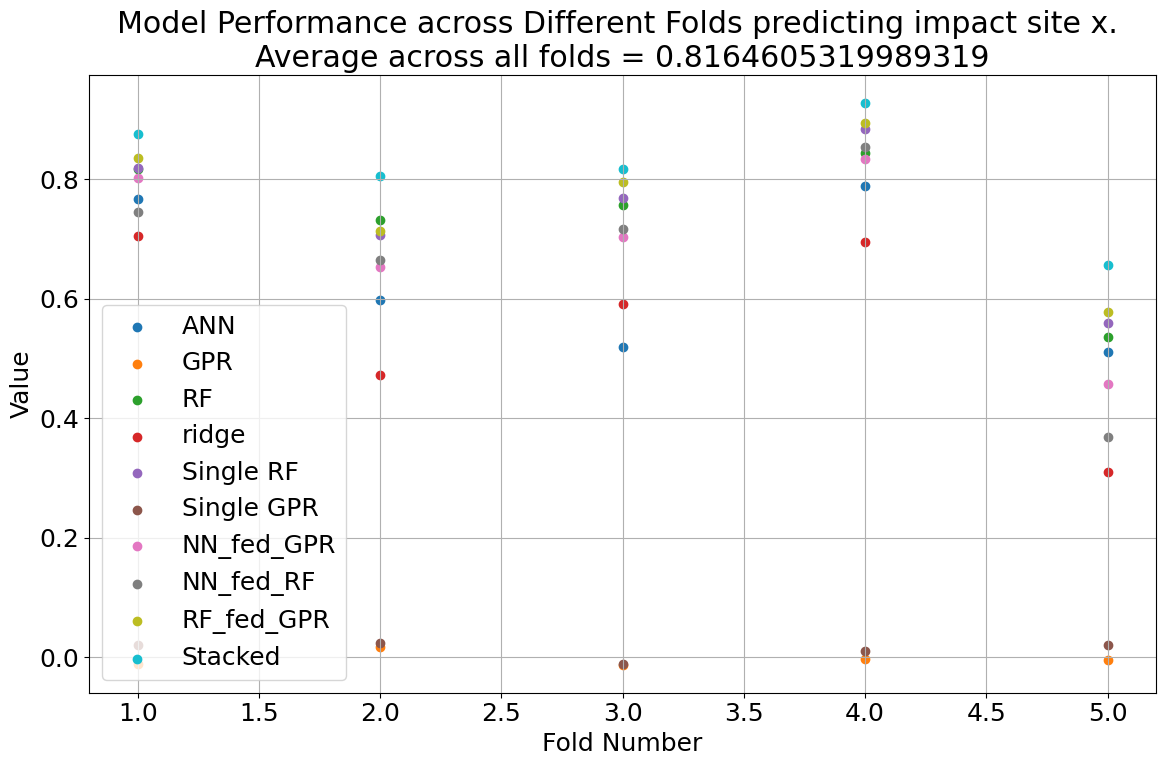

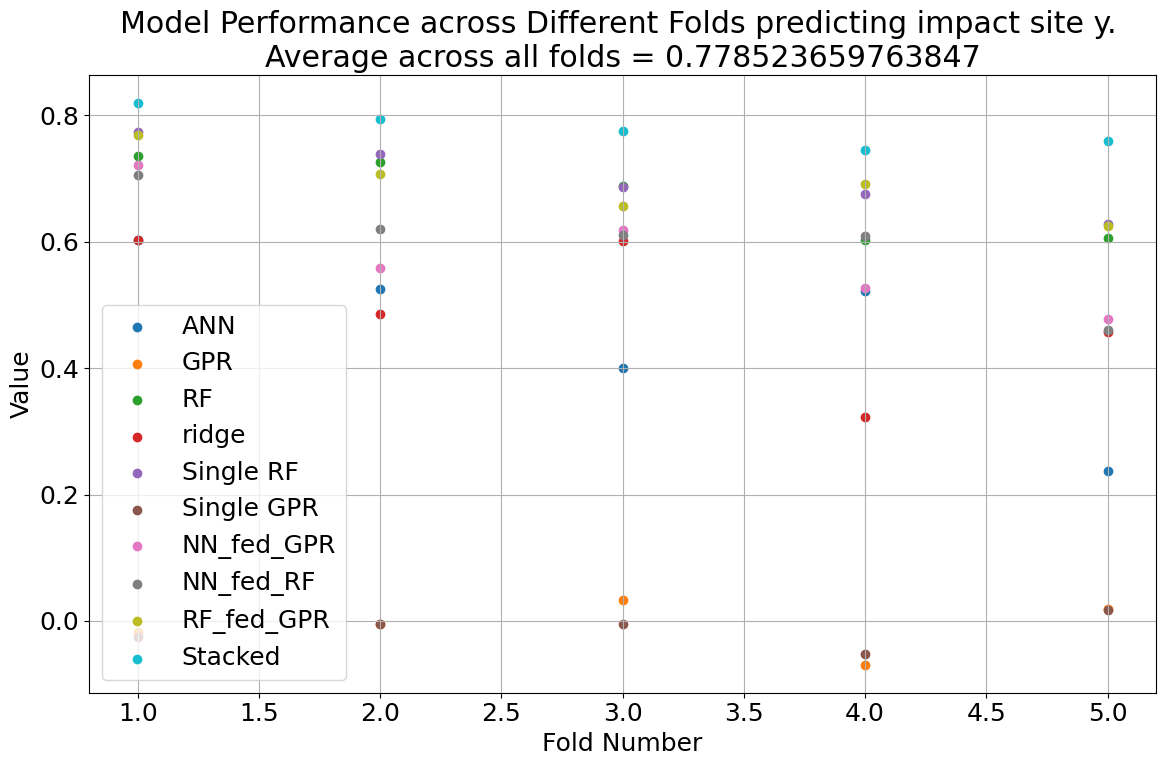

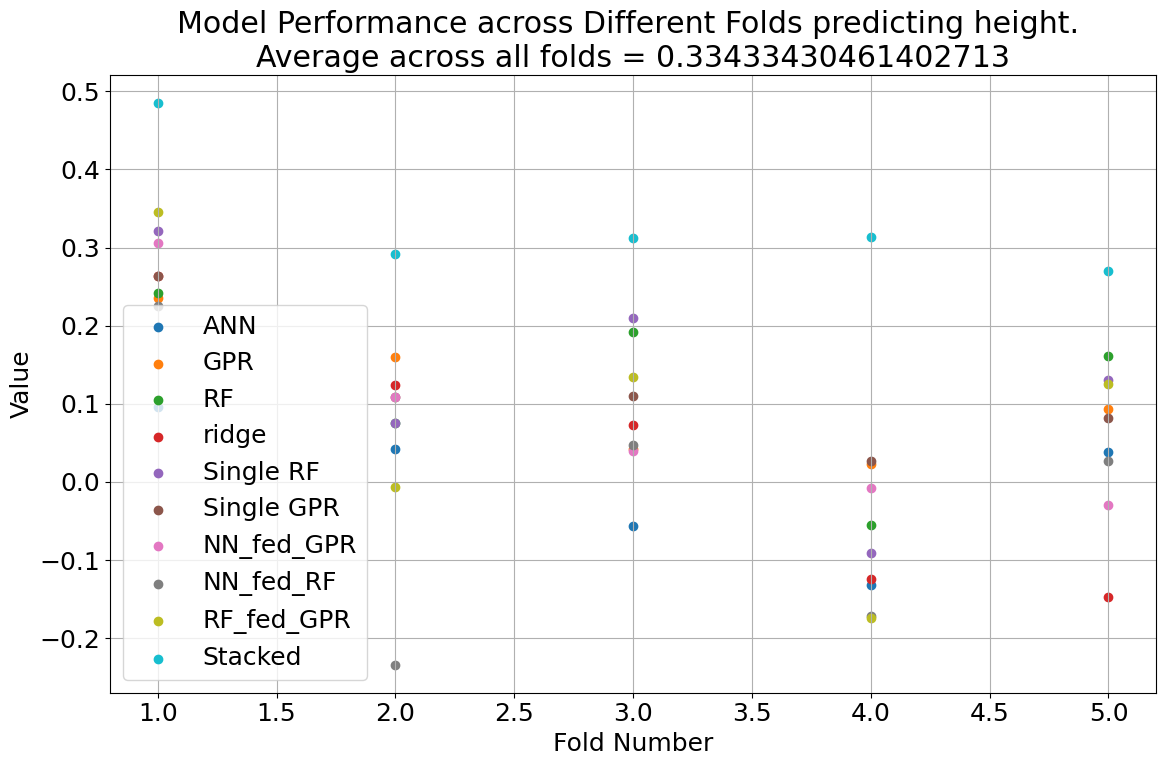

In [30]:
'''Now lets make some charts and see how stacking did compared to the base learners'''

def plot_data_all_folds(data, label_to_predict, average_stacked_score):
    # Extracting model types and their corresponding values for each fold
    fold_nos = list(data.keys())
    model_types = data[1].keys()

    # Plotting
    plt.figure(figsize=(12, 8))

    for model in model_types:
        values = [data[fold][model] for fold in fold_nos]
        plt.scatter(fold_nos, values, label=model)

    plt.xlabel('Fold Number')
    plt.ylabel('Value')
    plt.title(f'Model Performance across Different Folds predicting {label_to_predict}. \nAverage across all folds = {average_stacked_score}')
    plt.legend()
    plt.grid(True)
    plt.show()


for label_to_predict in labels_to_predict:
    all_fold_results = {}
    average_stacked_score = 0
    for fold_no in range(1,6):
        base_model_results = pd.read_csv(f'/Volumes/Jake_ssd/Stacking/stacking_results/base_models/{label_to_predict}/base_model_results_fold_{fold_no}.csv', index_col=0)
        stacked_model_results = pd.read_csv(f'/Volumes/Jake_ssd/Stacking/stacking_results/base_models/{label_to_predict}/stacked_model_results_fold_{fold_no}.csv', index_col=0)
        sorted_stacked_results = stacked_model_results.sort_values(by='Score', ascending=False)
        best_stacked_result = sorted_stacked_results.iloc[0]
        all_base_model_results = {}
        for model_type in model_types:
            all_base_model_results[model_type] = base_model_results[base_model_results['model_type'] == model_type]['score'].values[0]
    
        all_base_model_results['Stacked'] = best_stacked_result['Score']
        average_stacked_score += best_stacked_result['Score']
        all_fold_results[fold_no] = all_base_model_results
    average_stacked_score /= 5
    plot_data_all_folds(all_fold_results, label_to_predict, average_stacked_score)
    
    
    
